In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from dataclasses import dataclass

In [3]:
import kagglehub
path = kagglehub.dataset_download("marcopinamonti/alzheimer-mri-4-classes-dataset")
print("Path to dataset files:", path)

100%|██████████| 34.1M/34.1M [00:00<00:00, 138MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset/versions/1


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = "/root/.cache/kagglehub/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset/versions/1"
NUM_CLASSES = 4

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


Found 6400 files belonging to 1 classes.
Using 5120 files for training.
Found 6400 files belonging to 1 classes.
Using 1280 files for validation.


In [6]:
def preprocess_and_categorical(image, label):
    image = tf.keras.layers.Rescaling(1./255)(image)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

In [7]:
train_dataset = train_dataset.map(preprocess_and_categorical)
validation_dataset = validation_dataset.map(preprocess_and_categorical)
test_dataset = test_dataset.map(preprocess_and_categorical)

In [8]:
for images, labels in train_dataset.take(1):
    print(f'Train images shape: {images.shape}')
    print(f'Train labels shape: {labels.shape}')

for images, labels in validation_dataset.take(1):
    print(f'Validation images shape: {images.shape}')
    print(f'Validation labels shape: {labels.shape}')

for images, labels in test_dataset.take(1):
    print(f'Test images shape: {images.shape}')
    print(f'Test labels shape: {labels.shape}')

Train images shape: (32, 224, 224, 3)
Train labels shape: (32, 4)
Validation images shape: (32, 224, 224, 3)
Validation labels shape: (32, 4)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32, 4)


In [16]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 4
    IMG_HEIGHT: int = 224
    IMG_WIDTH: int = 224
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS: int = 3
    BATCH_SIZE: int = BATCH_SIZE
    LEARNING_RATE: float = 0.0001

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
optimizer = Adam(learning_rate=TrainingConfig.LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [17]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=TrainingConfig.EPOCHS,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 3481s 22s/step - accuracy: 0.9859 - loss: 0.0891 - val_accuracy: 1.0000 - val_loss: 0.1005 - learning_rate: 1.0000e-04
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 3445s 22s/step - accuracy: 0.9998 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 1.0000e-04
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 3506s 22s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 2.8487e-04 - learning_rate: 1.0000e-04


In [18]:
model.save("alzheimer_model.h5")

In [23]:
from tensorflow.keras.models import load_model
loaded_model = load_model("alzheimer_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


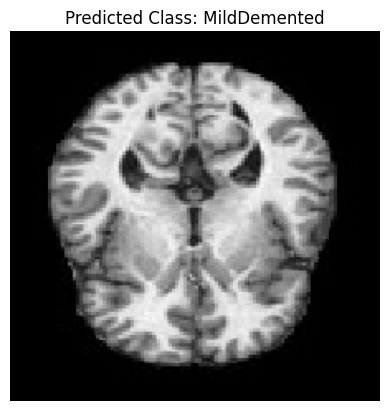

In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Adjust to match your class order

# Path to the new image
image_path = "/content/test_image.jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize as done during training

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name using the index
predicted_class_name = class_names[predicted_class]

# Display the image and predicted class name
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()
